In [1]:
%pylab inline
import astropy.units as u
import tmm
from LSSTFringe import utils,plot_utils,TMMSIM
from tqdm import tqdm
from numba import jit
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plot_utils.init_plot_style()
warnings.filterwarnings('ignore')

# By default, TS temperature is about 90 degeree
index_of_refraction = utils.load_refraction_data(Epoxy_ind=1.6,Temp = 183.)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Produce Figure 1 in the paper

def sim(save=None,struc = 'E2V',bandwidth = 1,avg_method = 'gaussian'):
    
    # pick up one of the CCD structures for simulation
    # Options:
    # 1. ITL sensor (Without litho-black)
    #    Layer composition and related thickness measured from https://arxiv.org/pdf/1911.09577.pdf
    # 2. E2V sensor
    #    Layer composition proposed by Criag. See fig 8(a) in the above paper by Criag.
    #
    # Both model implements Anti-Reflection coating composition given in document-8590 on LSST's Docushare site 
    # https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=215845587 by Andy Rasmussen
    
    if struc == 'E2V':
        material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
        thickness_um = (np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14,165, np.inf)

    elif struc == 'ITL':
        material = ['Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Vacuum']
        thickness_um = [np.inf, 0.1221,0.0441,100., 0.16, 0.341,0.41, np.inf]
        
    else:
        print("Error1: Input sturcuture Error")

    # Assume normal incidence.
    theta = 0
    
    # Simulation wavelength range 600nm - 1000nm
    # Need small spacing to recover all fringings and smooth curve
    num_pts = 8001
    wlens = [np.linspace(600., 1000., num_pts)]
    
    # Array stores the absorption power array (as a function of wavelength)
    As = []
    
    for j,wlen in enumerate(wlens):
        
        # Initialize Reflection and Transmission Power array
        R = np.zeros_like(wlen)
        T = np.zeros_like(wlen)
        
        for i, w in enumerate(wlen):
            n_list = [index_of_refraction[m](w) for m in material]
            
            # Polarization averaged
            for pol in 'sp':
                
                # Using tmm package to do multilayer thin-film simulation
                result = tmm.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * w)
                # Store R and T results
                R[i] += 0.5*result['R']
                T[i] += 0.5*result['T']
                
        # Absorption is simply: Unity - R - T
        A = 1 - R - T
        As.append(A)
    
    # Include the finite bandwidth of monochromatic light using either 'gaussian' or 'flat' profile
    
    if avg_method == 'flat':
        bandwidth_avg = average_flat(A,avg_wlen_width=bandwidth,num_pts=num_pts)
    if avg_method == 'gaussian':
        bandwidth_avg = average_gaussian(A,avg_wlen_width=bandwidth,num_pts=num_pts)
    if avg_method == 'None':
        bandwidth_avg = A
    
    
    return(bandwidth_avg)


# Include finite bandwidth of light assuming gaussian profile
def average_gaussian (coeff,avg_wlen_width = 2,num_pts = 8001):
    # coeff: the absorption power calculated from tmm
    # avg_wlen_width: bandpass of light
    # num_pts: number of points for wavelength array in simulation, used to determine window size
    
    # number of points correspond to 1nm wavelength spacing
    scale = (num_pts-1)//400
    
    # window determines the number of points used to calculated value at the central wavelength
    # Assuming the window size for averaging to be 4 times the bandwidth or FWHM of gaussian->
    # ->to sufficiently cover the full light profile
    window = int(2*avg_wlen_width*2*scale)
    
    # Define the gaussian function
    def gaussian(x, mu, FWHM):
        
        # Calculate sigma based on FWHM value 2nm
        # FWHM = 2*sqrt(2*ln2)*sigma
        
        sig = FWHM/(2*np.sqrt(2*np.log(2)))

        return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)
    
    # Assuming 2nm FWHM,weigh is fixed for each group of points
    # Derive the weight for 21*8 points for averaging
    x = np.linspace(800-avg_wlen_width*2,800+avg_wlen_width*2,window+1)
    # Assign weight to each point based on the gaussian
    weight = gaussian(x,800,avg_wlen_width)
    plt.plot(x,weight,'ro--',label = 'bandpass: %.inm'%avg_wlen_width)
    # Array to store the absorption power after averaging
    amp = []
    
    # Start averaging 
    for i,ab in enumerate(coeff):
        # At one central wavelength, do the averaging
        if i > (window//2) and i < (num_pts-window//2-1):
            amp.append(np.sum(coeff[i-window//2:i+window//2+1]*weight)/np.sum(weight))    
        # if not enough points for averaging (e.g hit the boundary the data array),treat as zero.
        elif i <= window//2:
            amp.append(0)
        else:
            amp.append(0)
            
    return(np.array(amp)) 


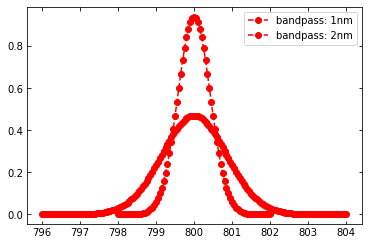

In [3]:
E2V_fringe_sim= sim(save=None,struc = 'E2V', avg_method = 'gaussian',bandwidth = 1)
E2V_fringe_sim2= sim(save=None,struc = 'E2V', avg_method = 'gaussian',bandwidth = 2)
plt.legend();

Text(0.07, 0.5, 'Absorption')

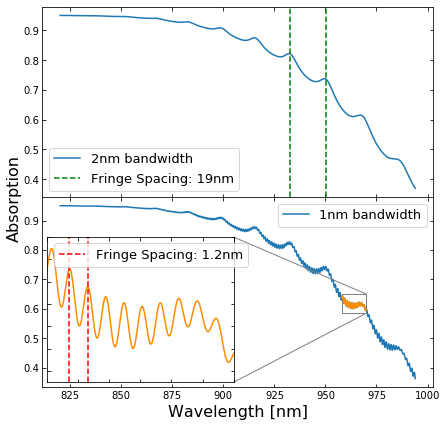

In [4]:
# Produce Figure 1 in the paper

wlen = np.linspace(600., 1000., 8001)
fig, (ax2, ax) = plt.subplots(2,1,figsize = (7,7),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.0)
ax.plot(wlen[2200*2:-60*2],E2V_fringe_sim[2200*2:-60*2],label ='1nm bandwidth')
ax.plot(wlen[3580*2:3700*2],E2V_fringe_sim[3580*2:3700*2],color = 'darkorange')

#ax.axhline(0.9,xmin = 0.631,xmax = 0.73,linewidth = 2,color = 'red')
#ax.axvspan(932.5,950.5,alpha = 0.2,label = 'Fringe Spacing: 19nm')
ax.legend(loc = 'upper right',fontsize = 13)
ax.set_xlabel('Wavelength [nm]',fontsize = 16)
axins = zoomed_inset_axes(ax,7.6, loc='lower left') # zoom = 6
axins.plot(wlen[2000*2:-60*2],E2V_fringe_sim[2000*2:-60*2],color = 'darkorange')

# Hard coded by visual inspection
x1, x2,y1,y2  = 958,970,0.585,0.65
axins.set_xlim(x1, x2)
axins.set_ylim(y1,y2)
axins.axvline(959.4,ls = '--',color = 'red')
axins.axvline(960.6,ls = '--',color = 'red',label = 'Fringe Spacing: 1.2nm')
#axins.axvspan(959.4,960.6,color = 'gray',alpha  = 1,label = 'Fringe Spacing: 1.2nm')
#axins.axhline(0.635,xmin = 0.115,xmax = 0.222,linewidth = 2,color = 'red')
axins.legend(loc = 'best',fontsize = 13)
mark_inset(ax, axins, loc1= 1, loc2=4, fc="none", ec="0.5")
plt.xticks(visible=False)
plt.yticks(visible=False)

ax2.plot(wlen[2200*2:-60*2],E2V_fringe_sim2[2200*2:-60*2],label = '2nm bandwidth')

ax2.axvline(950.5,ls = '--',color = 'green')
ax2.axvline(932.5,ls = '--',color = 'green',label = 'Fringe Spacing: 19nm')
ax2.legend(loc = 'best',fontsize = 13)
fig.text(0.07, 0.5, 'Absorption', fontsize = 16,ha='center', va='center', rotation='vertical')

In [14]:
@jit(nopython = True,nogil=True)
def E2V_model(n_list,epoxy_um, Si_um,wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,Si_um, 0.1, 0.3,1.,epoxy_um,165, np.inf])

    # Assume normal incidence.
    theta = 0.
    R = T = 0
    for pol in 's':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        rr,tt = Res[2],Res[3]
        R += rr
        T += tt

    A = 1 - R - T

    return(A)

# Define the gaussian function
@jit(nopython = True,nogil=True)
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma
    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)

# Run the simulation on a fudicial plane with thickness variation to compute fringing amplitude
@jit(nopython = True,nogil=True)
def map_sim(n_list,thickmap,thickmap2,wlen):
    Fringe_map = np.zeros_like(thickmap)
    for i in range(len(thickmap)):
        Fringe_map[i] = E2V_model(n_list = n_list,epoxy_um = thickmap[i],Si_um = thickmap2[i],wlen=wlen)
    return(Fringe_map)

In [20]:
wavelength = np.arange(800., 1100., 1)
MAP = np.arange(14,14.5,0.01)
MAP2 = np.ones(shape= MAP.size)*100
Fringe_amp = []
for m in tqdm(range(len(wavelength))):
    avg_wlen_width = 2
    window =80
    cen_wav = wavelength[m]
    x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)
    # Assign weight to each point based on the gaussian
    weight = gaussian(x,cen_wav,avg_wlen_width)
    Fringe_map = np.zeros_like(MAP)

    for k in (range(len(x))):
        wlen = x[k]
        material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
        n_list = np.array([index_of_refraction[m](wlen) for m in material])
        Fringe_map += weight[k]*map_sim(n_list,MAP,MAP2,wlen = x[k])
    Fringe_map = Fringe_map/np.sum(weight)       
    a = (np.max(Fringe_map)+np.min(Fringe_map))/2
    A = (Fringe_map)-a
    Fringe_amp.append(A[0])


100%|██████████| 300/300 [00:23<00:00, 12.91it/s]


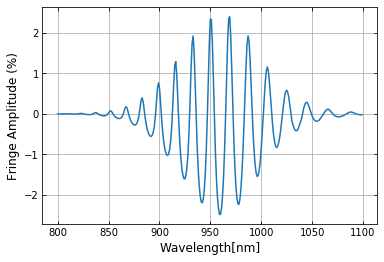

In [21]:
plt.plot(wavelength,np.array(Fringe_amp)*100)
plt.grid()
plt.xlabel('Wavelength[nm]',fontsize = 12)
plt.ylabel('Fringe Amplitude (%)',fontsize = 12);